## **SQL Murder Mystery**
Project author: Alyssa Ayala

COOP Careers SQL 104 project taken from [here](https://mystery.knightlab.com/), with GitHub reposiotry [here](https://github.com/NUKnightLab/sql-mysteries)

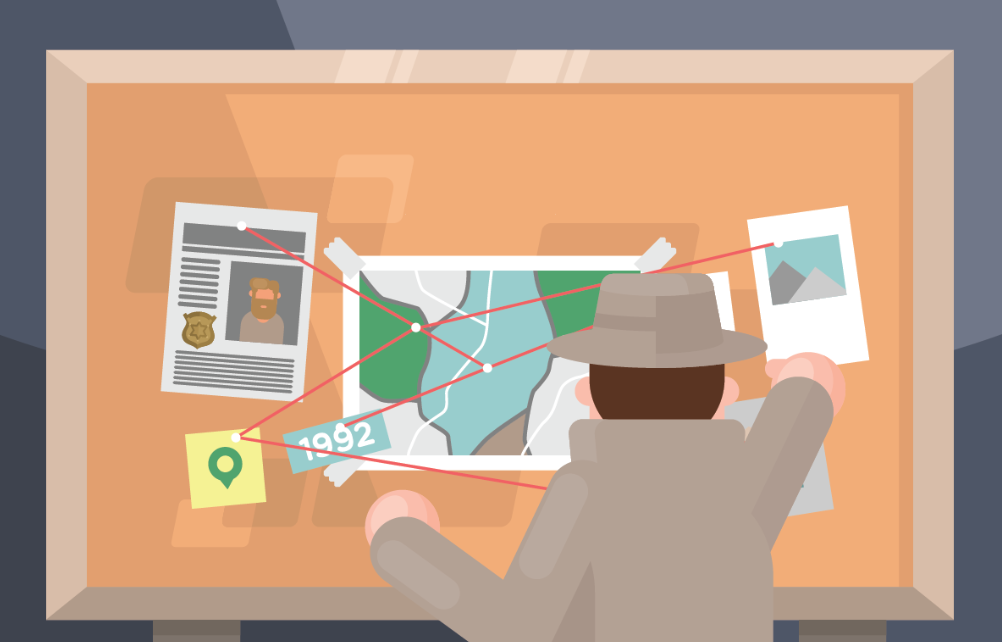

A horrific `murder` happened in `SQL City` on `January 15, 2018`. I am the detective for their Police Department, and my job is to use the SQL database to find the details of the crime. Below are the steps I took to crack the case.


## Conecting to the Police Department database

Before I do anything, I first need to load the Poice Department database. To do so, I need to install the SQL datase from its GitHub repository.

Please run the code below before proceeding to the next step.

In [ ]:
%%capture --no-stderr
# @title Press Play { display-mode: "form" }
# Install `teachdb` and `coop_grader`
print("Installing `teachdb` and its dependencies...")
%pip install --quiet --upgrade git+https://github.com/freestackinitiative/teachingdb.git git+https://github.com/martinmarroyo/coop_grader.git
print("Successfully installed `teachdb`")
from teachdb.teachdb import connect_teachdb
from coop_grader.sql_murder_mystery.check_suspect import check_suspect
# Set configurations for notebook & load data
con = connect_teachdb(database="sql_murder_mystery")

%sql con

## See the tables in the database

I need to learn the tables that I will be working with and their columns. This all comes from `information_schema.columns`, with their most important parts being `table_name`, `column_name`, and `data_type`.

In [ ]:
%%sql
SELECT table_name, column_name, data_type
FROM information_schema.columns
ORDER BY table_name, column_name;

,table_name,column_name,data_type
0,crime_scene_report,city,VARCHAR
1,crime_scene_report,date,INTEGER
2,crime_scene_report,description,VARCHAR
3,crime_scene_report,type,VARCHAR
4,drivers_license,age,INTEGER
5,drivers_license,car_make,VARCHAR
6,drivers_license,car_model,VARCHAR
7,drivers_license,eye_color,VARCHAR
8,drivers_license,gender,VARCHAR
9,drivers_license,hair_color,VARCHAR


Now that I know about the tables in detail, I need to figure out their relationships to each other so that I can connect multiple tables. These are mainly done with **primary** and **foreign** keys, where a primary key identifies a specific entry that could be connected to another dataset as a foreign one.
<details>
  <summary>Check the Entity Relationship Diagram:</summary>
  <img src="https://github.com/freestackinitiative/coop_sql_notebooks/blob/v2/assets/murder_mystery_schema.png?raw=1" alt="ERD for SQL City"/>
</details>


## Finding the police report

The `crime_scene_report` table will have the police report on this exact case. We already know the `date`, `type`, and `city`, so we'll see what the `description` tells us.

In [ ]:
%%sql

SELECT description
FROM crime_scene_report
WHERE date = '20180115' AND type = 'murder' AND city = 'SQL City';

,description
0,Security footage shows that there were 2 witnesses. The first witness lives at the last house o...


## The first witness

There were two witnesses, so now we will go further into these people to see exactly who they are and pull up their interviews based on their IDs.

The first one lives at the last house on `Northwestern Dr`:


In [ ]:
%%sql

SELECT id
FROM person
WHERE address_street_name = 'Northwestern Dr'
ORDER BY address_number DESC
LIMIT 1;

,id
0,14887


Looking up the interview for this person, we get these details:

In [ ]:
%%sql

SELECT transcript
FROM interview
WHERE person_id = 14887;

,transcript
0,"I heard a gunshot and then saw a man run out. He had a ""Get Fit Now Gym"" bag. The membership nu..."


**What we know about the murderer:**

*   He is a **gold member** at the Get Fit Now Gym.
*   The getaway car's plate includes 'H42W'.

Let's look more into the possible cars. We can use a **subquery** to get the person ids from the license ids.



In [ ]:
%%sql

SELECT id
FROM person
WHERE license_id IN (
  SELECT id
  FROM drivers_license
  WHERE plate_number LIKE '%H42W%'
);


,id
0,51739
1,67318
2,78193


Now we have narrowed it down to three suspects. Using their `person` ids, we can see if any of them are gold members at the gym:

In [ ]:
%%sql

SELECT name
FROM get_fit_now_member
WHERE person_id IN (
  SELECT id
  FROM person
  WHERE license_id IN (
    SELECT id
    FROM drivers_license
    WHERE plate_number LIKE '%H42W%'
  )
);

,name
0,Jeremy Bowers


So our murderer is `Jeremy Bowers`... _we didn't even need the 2nd witness!_ But let's quickly look at their details to see what information we can find for the sake of this project.

For example, imagine multiple suspects had gold memberships. It'd be helpful to have some sort of check-in or check-out time to narrow them down!

## The second witness

From the crime scene report earlier, we know that the second witness's first name is `Annabel`, and she lives on `Franklin Ave`. Let's pull up her interview:

In [ ]:
%%sql

SELECT transcript
FROM interview
WHERE person_id IN (
  SELECT id
  FROM person
  WHERE name LIKE 'Annabel%' AND address_street_name = 'Franklin Ave'
);

,transcript
0,"I saw the murder happen, and I recognized the killer from my gym when I was working out last we..."


What we know about the murderer:

*   He is a gym member.
*   He worked out on January 9th.

Let's see the details on Annabel's gym trip on January 9th:



In [ ]:
%%sql

SELECT *
FROM get_fit_now_check_in
WHERE check_in_date = '20180109' AND membership_id IN (
  SELECT id
  FROM get_fit_now_member
  WHERE person_id IN (
    SELECT id
    FROM person
    WHERE name LIKE 'Annabel%' AND address_street_name = 'Franklin Ave'
  )
);

,membership_id,check_in_date,check_in_time,check_out_time
0,90081,20180109,1600,1700


We can use the check-in times to eliminate gym members as suspects. This would mean anyone who checked out before `1600` is _not_ a suspect, because Annabel could not have seen them.

In [ ]:
%%sql

SELECT *
FROM get_fit_now_check_in
WHERE check_in_date = '20180109' AND check_out_time >='1600';

,membership_id,check_in_date,check_in_time,check_out_time
0,48Z7A,20180109,1600,1730
1,48Z55,20180109,1530,1700
2,90081,20180109,1600,1700


This leaves us with two possible suspects: `48Z7A` and `48Z55`. In this case, we would need more details. This is why it's important to have multiple witnesses, even if you think one is enough.

## Finding the _real_ villain!

Even though `Jeremy Bowers` did the murder, was it really his idea? Was he perhaps manipulated in some way? I decided to give him the benefit of the doubt and look into his interview transcript:

In [ ]:
%%sql

SELECT transcript
FROM interview
WHERE person_id IN (
  SELECT id
  FROM person
  WHERE name = 'Jeremy Bowers'
);

,transcript
0,"I was hired by a woman with a lot of money. I don't know her name but I know she's around 5'5"" ..."


According to Jeremy, he was hired by a woman to commit the crime. He doesn't know her name, but he gave many helpful details about her. Let's use this information to find out who hired him. Here's what we know about her:
*   She is rich.
*   She's either 65" or 67".
*   She has red hair
*   She drives a Tesla with Model S.
*   She attended the SQL Symphony Concert 3 times in December 2017.

It's likely that we may not need all of these details. For example, her richness would be related to the `income` table, and her concerts would be related to the `facebook_event_checkin` tables.

Let's see what we can get based on her physical looks and concerts:



In [ ]:
%%sql

SELECT name
FROM person p
JOIN drivers_license d
ON p.license_id = d.id
WHERE hair_color = 'red'
  AND car_make = 'Tesla'
  AND car_model = 'Model S'
  AND height BETWEEN 65 AND 67
  AND p.id IN (
    SELECT person_id
    FROM facebook_event_checkin
    WHERE event_name = 'SQL Symphony Concert'
  );

,name
0,Miranda Priestly


So the real villain is **Miranda Priestly!** While Jeremy Bowers will also be punished, the Police Department's next steps would be to arrest Priestly and determine her punishment.

This concludes my case.